<a href="https://colab.research.google.com/github/joshsalako/dsn/blob/main/DSN_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset

In [ ]:
# Package to have access to the Zindi Platform features
!pip -q install git+https://github.com/eaedk/testing-zindi-package.git

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
#@title Input Username
# Login info for a Zindi Account

USERNAME = "josh_salako" #@param {type : "string"}

In [ ]:
from zindi.user import Zindian
user = Zindian(username=USERNAME) # Sign in                                             # , fixed_password=PASSWORD

Your password
>> ··········

[ 🟢 ] 👋🏾👋🏾 Welcome josh_salako 👋🏾👋🏾



In [ ]:
user.select_a_challenge(reward='knowledge', kind='hackathon', active='true')                               # Select a Zindi challenge

__________________________________________________________________________________________________________________________________
|     |              |                  |                    |          
|index|  challenge   |     problem      |       reward       |    id    
|     |              |                  |                    |          
----------------------------------------------------------------------------------------------------------------------------------
|  0  | Private Hack |Natural Language P|      E50 000       | indabax-eswatini-2023...
----------------------------------------------------------------------------------------------------------------------------------
|  1  | Public Hack  |    Prediction    |     Knowledge      | free-ai-classes-in-every-city-hackathon-2023...
----------------------------------------------------------------------------------------------------------------------------------
|  2  | Private Hack |Sentiment Analysis|     Knowledge   

In [ ]:
user.which_challenge                                    # Get information about the selected challenge


[ 🟢 ] You are currently enrolled in : free-ai-classes-in-every-city-hackathon-2023 challenge,
	Can you accurately predict the prices of houses in Nigeria..



'free-ai-classes-in-every-city-hackathon-2023'

In [ ]:
user.download_dataset(destination="dataset") # Download the dataset of the selected challenge

HTTPError: ignored

In [ ]:
!unzip /content/free-ai-classes-in-every-city-hackathon-2023.zip

Archive:  /content/free-ai-classes-in-every-city-hackathon-2023.zip
  inflating: Sample_submission.csv   
  inflating: Housing_dataset_train.csv  
  inflating: Housing_dataset_test.csv  


# Import Modules

In [ ]:

!pip install catboost
import numpy as np
from catboost import CatBoostRegressor
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression,ElasticNet, Ridge
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Normalizer,  LabelEncoder
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [ ]:
train =  pd.read_csv('/content/Housing_dataset_train.csv')
test =  pd.read_csv('/content/Housing_dataset_test.csv')
sample =  pd.read_csv('/content/Sample_submission.csv')

# EDA

In [ ]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [ ]:
# General statistics
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [ ]:
train.shape

(14000, 7)

In [ ]:
train.duplicated().sum()

0

In [ ]:
train.isna().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [ ]:
# Dealing with empty rows
train.dropna(inplace=True)

In [ ]:
train.nunique()

ID               4957
loc                36
title              10
bedroom             9
bathroom            7
parking_space       6
price            4987
dtype: int64

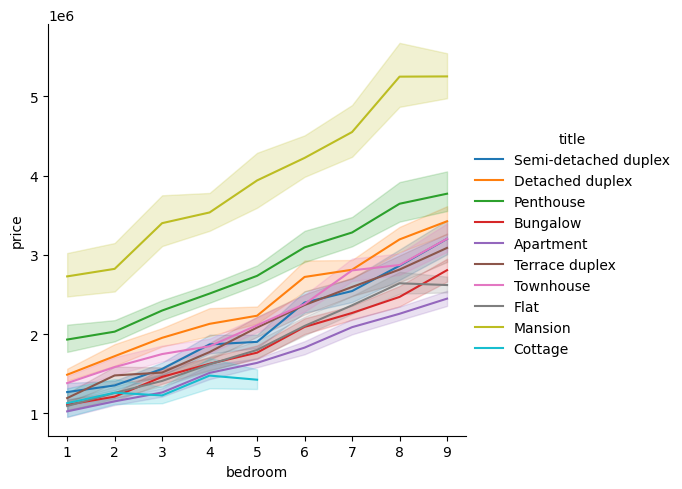

In [ ]:
sns.relplot(x = train['bedroom'], y=train['price'], hue =train['title'], kind = 'line')

This visualization shows that generally prices of houses increase with increase in number of bedrooms with Mansions as the most expensive of all

<Axes: xlabel='price', ylabel='Count'>

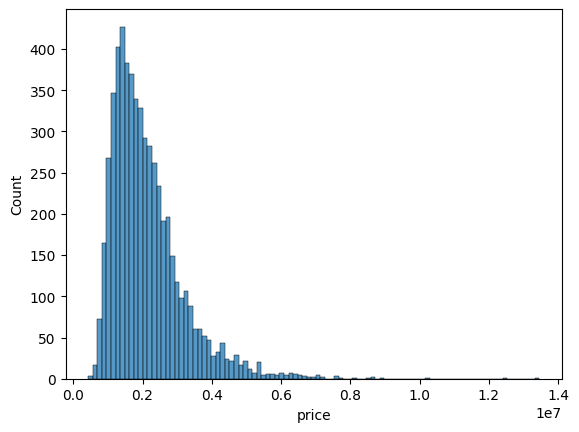

In [ ]:
sns.histplot(train.price)

This shows that price distribution is skewed

<Axes: xlabel='price', ylabel='loc'>

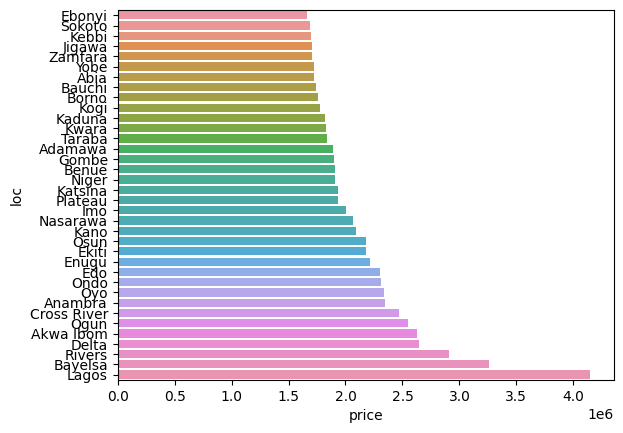

In [ ]:
_ = train.groupby(['loc'])['price'].mean()
_ = _.to_frame().sort_values('price')
sns.barplot(y=_.index, x=_.price)

Lagos comes first with the highest mean house prices with Ebony as the least expensive in all locations

In [ ]:
# Correlation Matrix
train.corr()

,ID,bedroom,bathroom,parking_space,price
ID,1.000000,0.234549,0.334921,0.179464,0.178304
bedroom,0.234549,1.000000,0.235722,0.113282,0.535665
bathroom,0.334921,0.235722,1.000000,0.180620,0.224481
parking_space,0.179464,0.113282,0.180620,1.000000,0.119511
price,0.178304,0.535665,0.224481,0.119511,1.000000


## Feature Engineering

In [ ]:
# Column showing how much bathrooms goes to one bedroom
train['bath_to_bed_ratio'] = train.bathroom/train.bedroom
test['bath_to_bed_ratio'] = test.bathroom/test.bedroom

### Dealing with categorical data

In [ ]:
train_df = pd.get_dummies(train, columns=['loc', 'title'],
                          drop_first=True)
train_df.head()

,ID,bedroom,bathroom,parking_space,price,bath_to_bed_ratio,loc_Adamawa,loc_Akwa Ibom,loc_Anambra,loc_Bauchi,...,loc_Zamfara,title_Bungalow,title_Cottage,title_Detached duplex,title_Flat,title_Mansion,title_Penthouse,title_Semi-detached duplex,title_Terrace duplex,title_Townhouse
0,3583,2.0,2.0,1.0,1149999.565,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2224,5.0,2.0,4.0,2410306.756,0.400000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
7,3003,3.0,3.0,5.0,2043107.592,1.000000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,12573,1.0,2.0,6.0,1330213.036,2.000000,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11,2624,3.0,4.0,2.0,1891772.069,1.333333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df = pd.get_dummies(test, columns=['loc', 'title'],
                          drop_first=True)
test_df.drop('ID', axis=1, inplace=True)
test_df.head()

,bedroom,bathroom,parking_space,bath_to_bed_ratio,loc_Adamawa,loc_Akwa Ibom,loc_Anambra,loc_Bauchi,loc_Bayelsa,loc_Benue,...,loc_Zamfara,title_Bungalow,title_Cottage,title_Detached duplex,title_Flat,title_Mansion,title_Penthouse,title_Semi-detached duplex,title_Terrace duplex,title_Townhouse
0,4,1,2,0.250000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,2,4,1.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,7,2,3.500000,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,9,5,2,0.555556,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,6,1,1.200000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
test_df.shape

(6000, 48)

# Modelling

In [ ]:
# Splitting dat to test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['ID', 'price'], axis=1).values,
                                                    train_df['price'].values,
                                                    test_size=0.2, random_state=42)

In [ ]:
# Log transform to deal with skewness
y_train = np.log(y_train)
y_test = np.log(y_test)

## Training

### XGBoost

In [ ]:
# Define the XGBoost regressor
regressor = xgb.XGBRegressor(objective="reg:squarederror")

# Define the hyperparameter space for random search
param_dist = {
  "n_estimators": [100, 200, 300, 400, 500],
  "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
  "max_depth": [3, 5, 7, 9, 11],
  "min_child_weight": [1, 3, 5, 7, 9],
  "subsample": [0.7, 0.8, 0.9, 1.0],
  "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
  "gamma": [0, 0.1, 0.2, 0.3, 0.4],
  "reg_alpha": [0, 0.001, 0.01, 0.1, 1.0],
  "reg_lambda": [0, 0.001, 0.01, 0.1, 1.0]
}

In [ ]:
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    regressor, param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error',
    cv=5, verbose=1, random_state=42, n_jobs=-1
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters found
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
best_params = {'subsample': 1.0, 'reg_lambda': 0.001, 'reg_alpha': 1.0,'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}

In [ ]:
# Train the XGBoost regressor with the best hyperparameters
best_regressor = xgb.XGBRegressor(**best_params, objective="reg:squarederror")
best_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Make predictions on the test set
y_pred = best_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 0.01310434122756623


### Linear Regressor

In [ ]:
linear_model = LinearRegression()

# Step 5: Define hyperparameter search space (if required, add more hyperparameters to the dictionary)
param_dist = {
    'fit_intercept': [True, False],
   # 'normalize': [True, False]
}

# Step 6: Perform RandomizedSearchCV to find the best model
random_search = RandomizedSearchCV(linear_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Print the best hyperparameters and best score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'fit_intercept': True}
Best Score: 0.9269833358221033


In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 0.014053664687887562


### CatBoost

In [ ]:
# Define the CatBoost Regressor model
catboost_model = CatBoostRegressor(verbose=0)

# Define the hyperparameter grid for RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter distributions for CatBoost Regressor
param_grid = {
    'iterations': randint(100, 1001),          # Number of boosting iterations
    'depth': randint(1, 11),                   # Depth of the trees
    'learning_rate': uniform(0.001, 0.1),      # Learning rate for boosting process
    'l2_leaf_reg': uniform(1, 10),             # L2 regularization term
    'bagging_temperature': uniform(0, 1),      # Control overfitting by using bagging
}


# Perform RandomizedSearchCV to find the best model
random_search = RandomizedSearchCV(
    catboost_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',  # Use a suitable metric for regression tasks
    cv=5,  # Cross-validation folds
    random_state=42,
    n_jobs=-1,  # Use all available CPU cores
)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Get the best model
best_catboost_model = random_search.best_estimator_

# Print the best hyperparameters and its corresponding mean squared error
print("Best Hyperparameters:", random_search.best_params_)
print("Best Mean Squared Error:", -random_search.best_score_)

In [ ]:
# Make predictions on the test set
y_pred = best_catboost_model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 0.012756846538419875


### MLP

In [ ]:
# Define the parameter grid for random search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}


# Create the MLPRegressor model
mlp = MLPRegressor(verbose=0, random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=20, cv=5, random_state=42)

# Perform the random search with cross-validation
random_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_mlp_model = random_search.best_estimator_
best_mlp_params = random_search.best_params_

print("Best MLPRegressor Model:")
print(best_mlp_model)
print("\nBest Hyperparameters:")
print(best_mlp_params)

Best MLPRegressor Model:
MLPRegressor(activation='tanh', hidden_layer_sizes=(50,), random_state=42,
             solver='lbfgs', verbose=0)

Best Hyperparameters:
{'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'tanh'}


In [ ]:
# Make predictions on the test set
y_pred = best_mlp_model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 0.01386207248799504


### Ensemble Model

In [ ]:
# Create ensemble model
ensemble_model = VotingRegressor(
    estimators=[
('linear', best_model),
('xgb', best_regressor),
#("catboost", best_catboost_model),
("MLP", best_mlp_model)
]
)

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model on the test set
test_score = ensemble_model.score(X_test, y_test)
print(f"Ensemble Model Test R^2 Score: {test_score:.2f}")

Ensemble Model Test R^2 Score: 0.94


In [ ]:
# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 0.012319537900334798


## Predicition and Submission

In [ ]:
# Perform inverse log on prediction
predictions = np.exp(ensemble_model.predict(test_df))
predictions

array([2338386.6907275 , 1045772.49613033, 1253381.40183429, ...,
       2000090.87517235, 1296194.9955088 , 3294625.82757624])

In [ ]:
sample['price']=np.round(predictions, 2)
sample.head()

,ID,price
0,845,2338386.69
1,1924,1045772.50
2,10718,1253381.40
3,12076,9327307.64
4,12254,1794611.48


## Make submission

In [ ]:
sample.to_csv('cate.csv', index=False)

In [ ]:
user.submit(filepaths=['/content/cate.csv'], comments=['26th submission'])

Submit content/cate.csv: 100%|█████████████████████████████████| 93.0k/93.0k [00:01<00:00, 48.7ko/s]


[ 🟢 ] Submission ID: qhevLPN2 - File submitted : /content/cate.csv

